In [9]:
%matplotlib notebook
from copy import deepcopy as copy
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import scipy.io as sio
import pandas as pd
from tqdm import tqdm
import pickle
from collections import OrderedDict
import os
from scipy.ndimage.interpolation import shift
from functools import reduce
import time

from aux import Generic
from disp import set_font_size, get_spaced_colors
from ntwk import LIFNtwkG
from utils.general import *
from utils.file_io import *


In [11]:
def animate(direc, frame_rate, v_max, cmap='hot', kind='w_r_e'):
    file_names = [f for f in sorted(all_files_from_dir(direc))]
    plt.ion()
    fig, ax = plt.subplots(1, 1, figsize=(6, 6), tight_layout=True)

    for i_f in range(0, len(file_names), frame_rate):
        file = file_names[i_f]
        loaded = sio.loadmat(os.path.join(direc, file))
        if i_f == 0:
            w_r_initial = copy(loaded[kind])
            
        graph_weight_matrix(loaded[kind], f'{i_f}', ax=ax, v_max=v_max, cmap=cmap)
        fig.canvas.draw()
        time.sleep(0.000001)
    
    loaded = sio.loadmat(os.path.join(direc, file_names[-1]))
    graph_weight_matrix(loaded[kind], f'{len(file_names) - 1}', ax=ax, v_max=v_max, cmap=cmap)
    w_r_final = copy(loaded[kind])
    return w_r_initial, w_r_final

In [21]:
def graph_avgs(direc):
    file_names = [f for f in sorted(all_files_from_dir(direc))]
    plt.ion()
    fig, ax = plt.subplots(1, 1, figsize=(6, 6), tight_layout=True)

    for i_f in range(0, len(file_names), 1):
        file = file_names[i_f]
        loaded = sio.loadmat(os.path.join(direc, file))
        ax.scatter([i_f], loaded['avg_input_per_cell'], c='black', s=5)
        try:
            ax.scatter([i_f], loaded['avg_input_per_cell_e_i'], c='red', s=5)
        except KeyError as e:
            pass

In [22]:
def plot_w_r(w_r, row_min=0, row_max=None, col_min=0, col_max=None):
    if row_max is None:
        row_max = w_r.shape[0]
    if col_max is None:
        col_max = w_r.shape[1]
    target_w_r = w_r[row_min:row_max, col_min:col_max]
    incoming_weights = target_w_r.sum(axis=1)
    fig, ax = plt.subplots(3, 1, figsize=(7, 9), tight_layout=True)
    ax[0].scatter(np.arange(len(incoming_weights)), incoming_weights, s=3)
    ax[0].set_ylabel('Summed Incoming Synapse Strength')
    
    print(f'average summed incoming weight per cell: {np.mean(incoming_weights)} +/- {np.std(incoming_weights)}')

    thresh = 1e-6
    thresholded = np.where(target_w_r > thresh, 1, 0)
    thresholded_target_w_r = np.where(thresholded, target_w_r, np.nan)
    counts = np.count_nonzero(thresholded, axis=1)
    print(f'average incoming connections per cell: {np.mean(counts)} +/- {np.std(counts)}')

    ax[1].fill_between(x=np.arange(len(incoming_weights)),
                   y1=np.nanmean(thresholded_target_w_r, axis=1) - np.nanstd(thresholded_target_w_r, axis=1)/np.sqrt(counts),
                   y2=np.nanmean(thresholded_target_w_r, axis=1) + np.nanstd(thresholded_target_w_r, axis=1)/np.sqrt(counts),
                    color='red', alpha=0.2)

    ax[1].scatter(np.arange(len(incoming_weights)), np.nanmean(thresholded_target_w_r, axis=1), s=1, c='red')  
    
    ax[1].set_ylabel('Incoming Individual Synapse Strength')

    ax[2].scatter(np.arange(len(counts)), counts, c='red', s=3)
    ax[2].set_xlabel('Neuron Idx')
    ax[2].set_ylabel('Num Connections over Threshold')

<IPython.core.display.Javascript object>


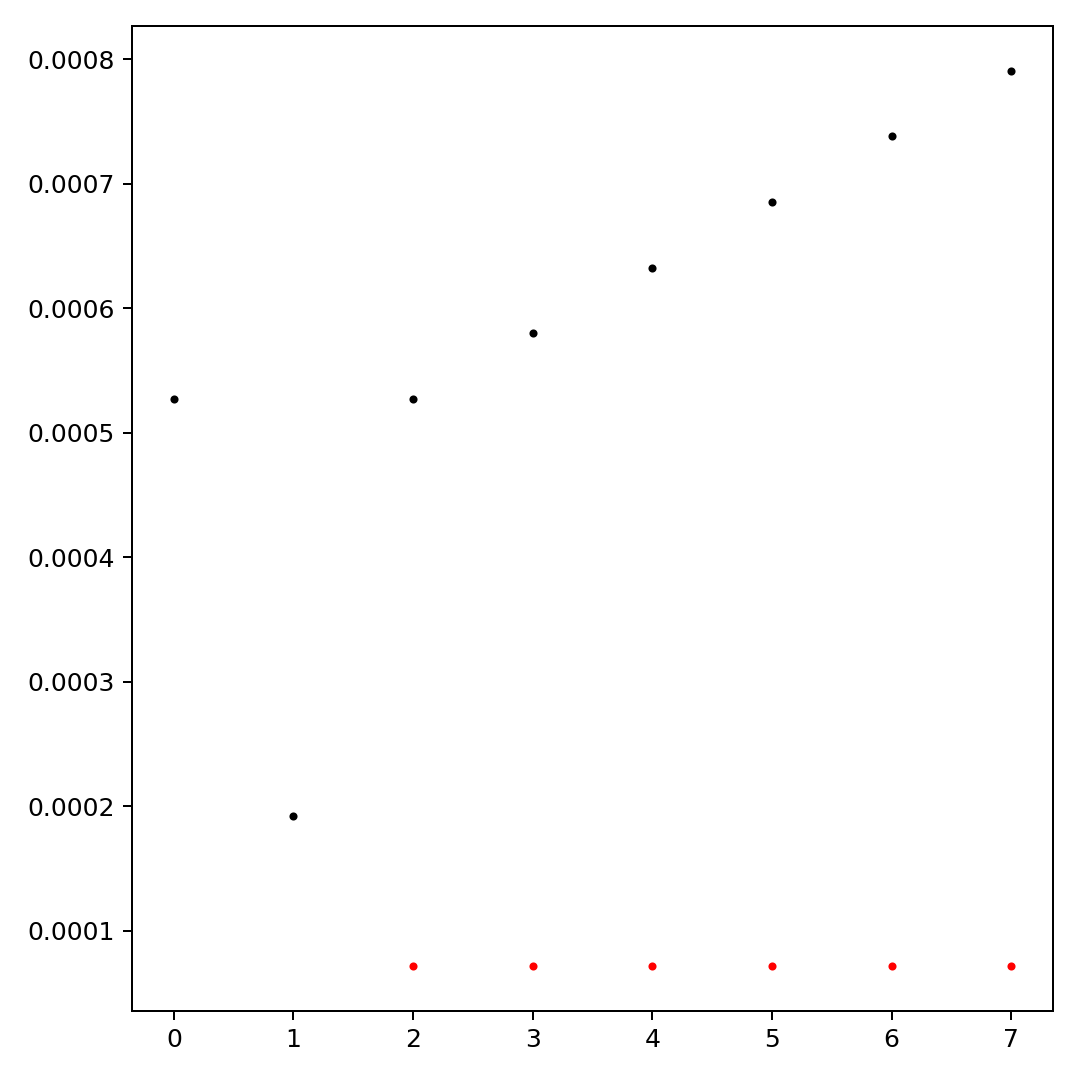

In [25]:
graph_avgs('./data/noise_ff_1.1_pf_0.3_pr_0.1_eir_2.0_ier_0.3_dropout_sweep_2021-03-12--00:16--18:9821_0_0')

<IPython.core.display.Javascript object>


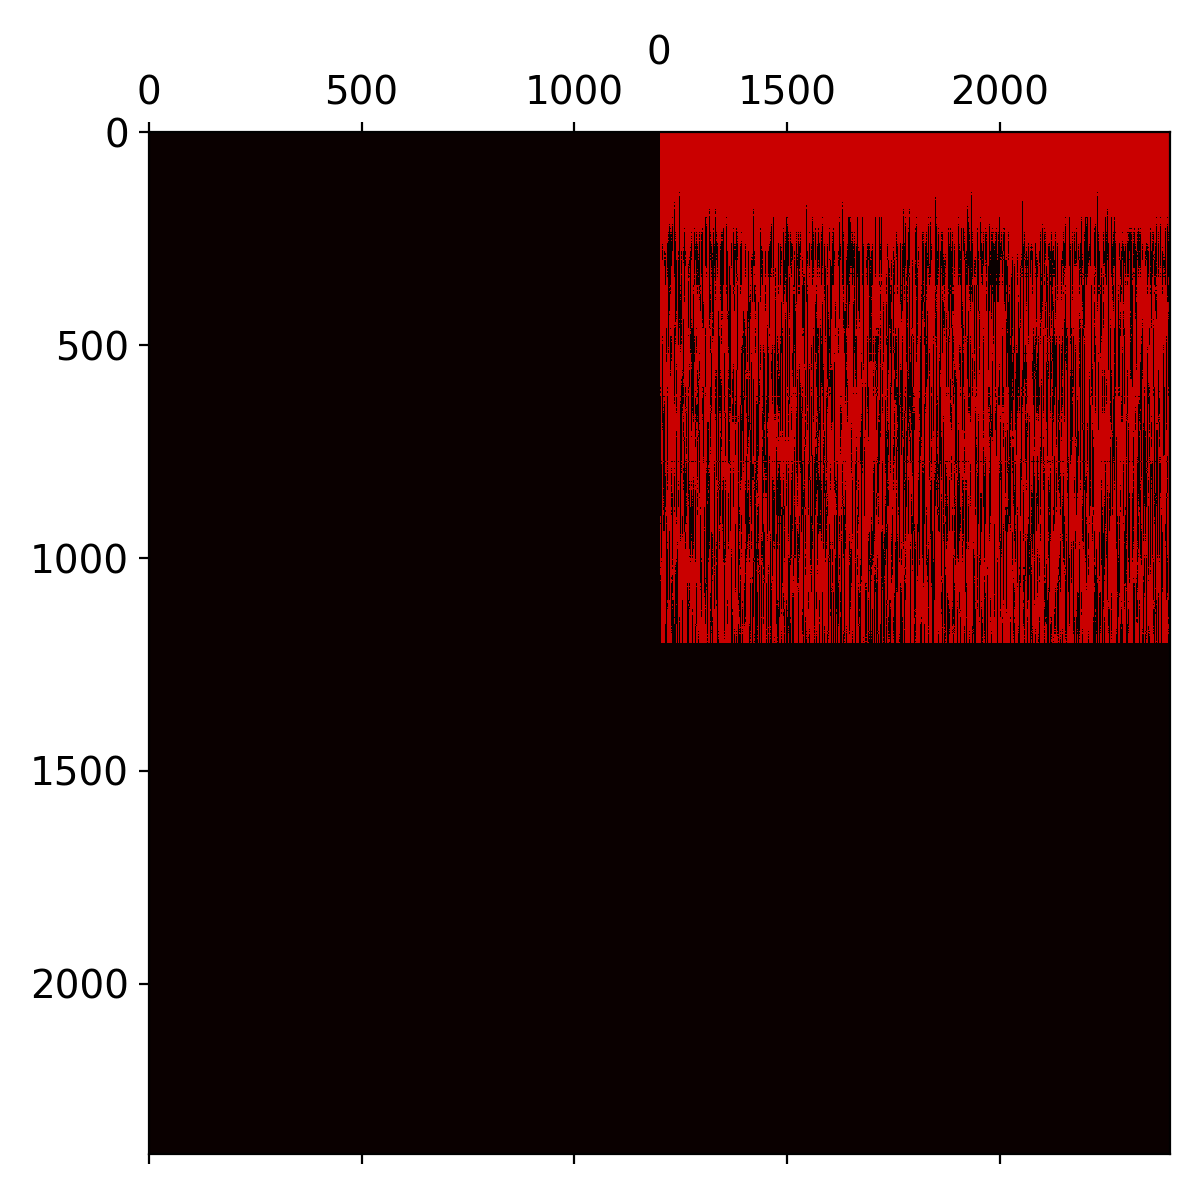

In [33]:
w_r_i_initial, w_r_i_final = animate('./data/noise_ff_1.1_pf_0.3_pr_0.1_eir_2.0_ier_0.3_dropout_sweep_2021-03-11--22:39--15:0986_0_0', 1, 0.26 * 0.004 * 0.1 / 10,
                                 cmap='hot', kind='w_r_i')

<IPython.core.display.Javascript object>


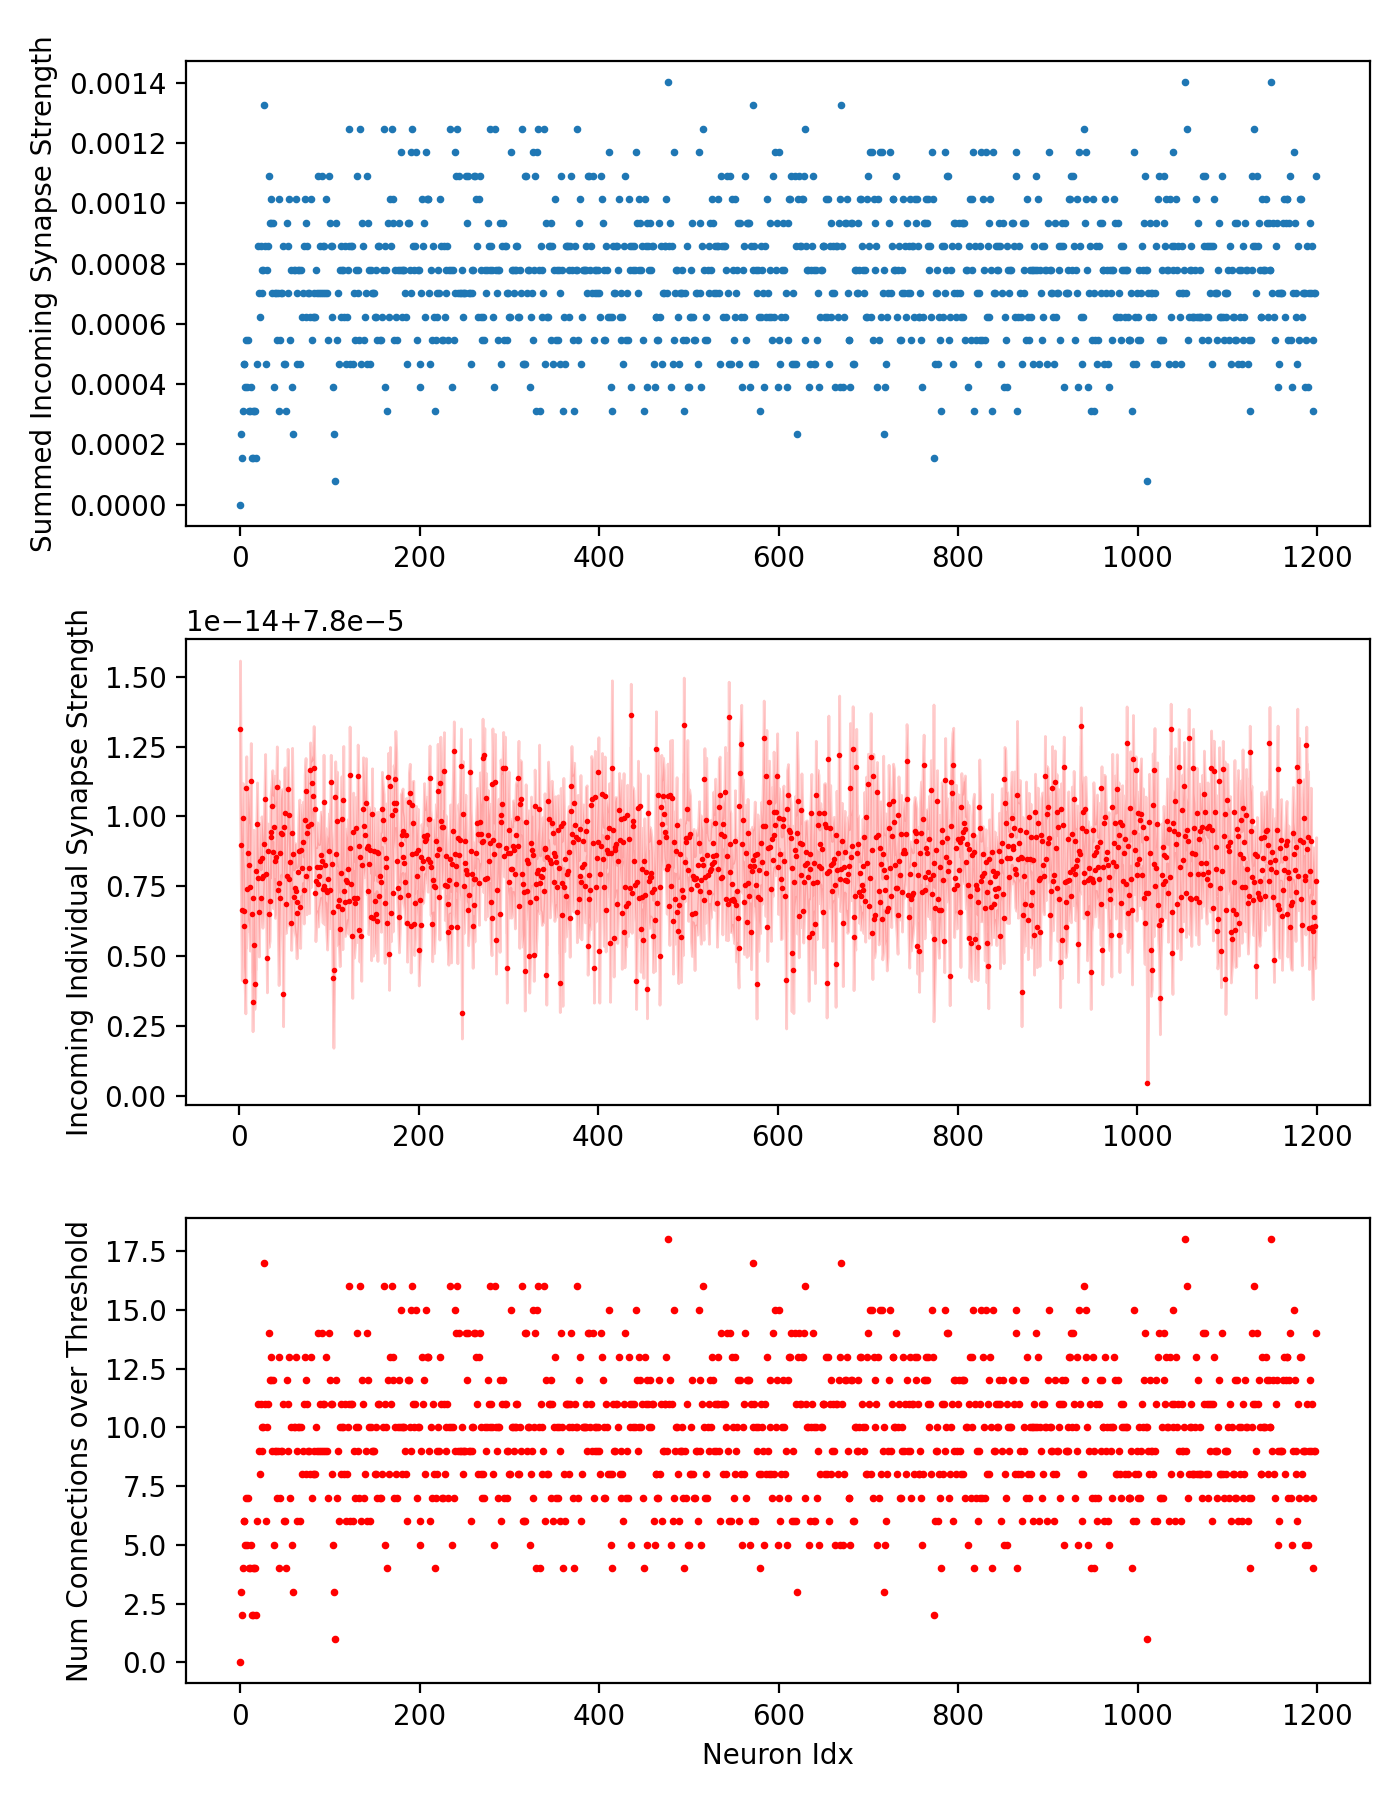

average summed incoming weight per cell: 0.0007495150003263509 +/- 0.00021978497395615005
average incoming connections per cell: 9.609166666666667 +/- 2.8177560763053204


In [36]:
plot_w_r(w_r_e_initial, row_max=1200, col_max=1200)

<IPython.core.display.Javascript object>


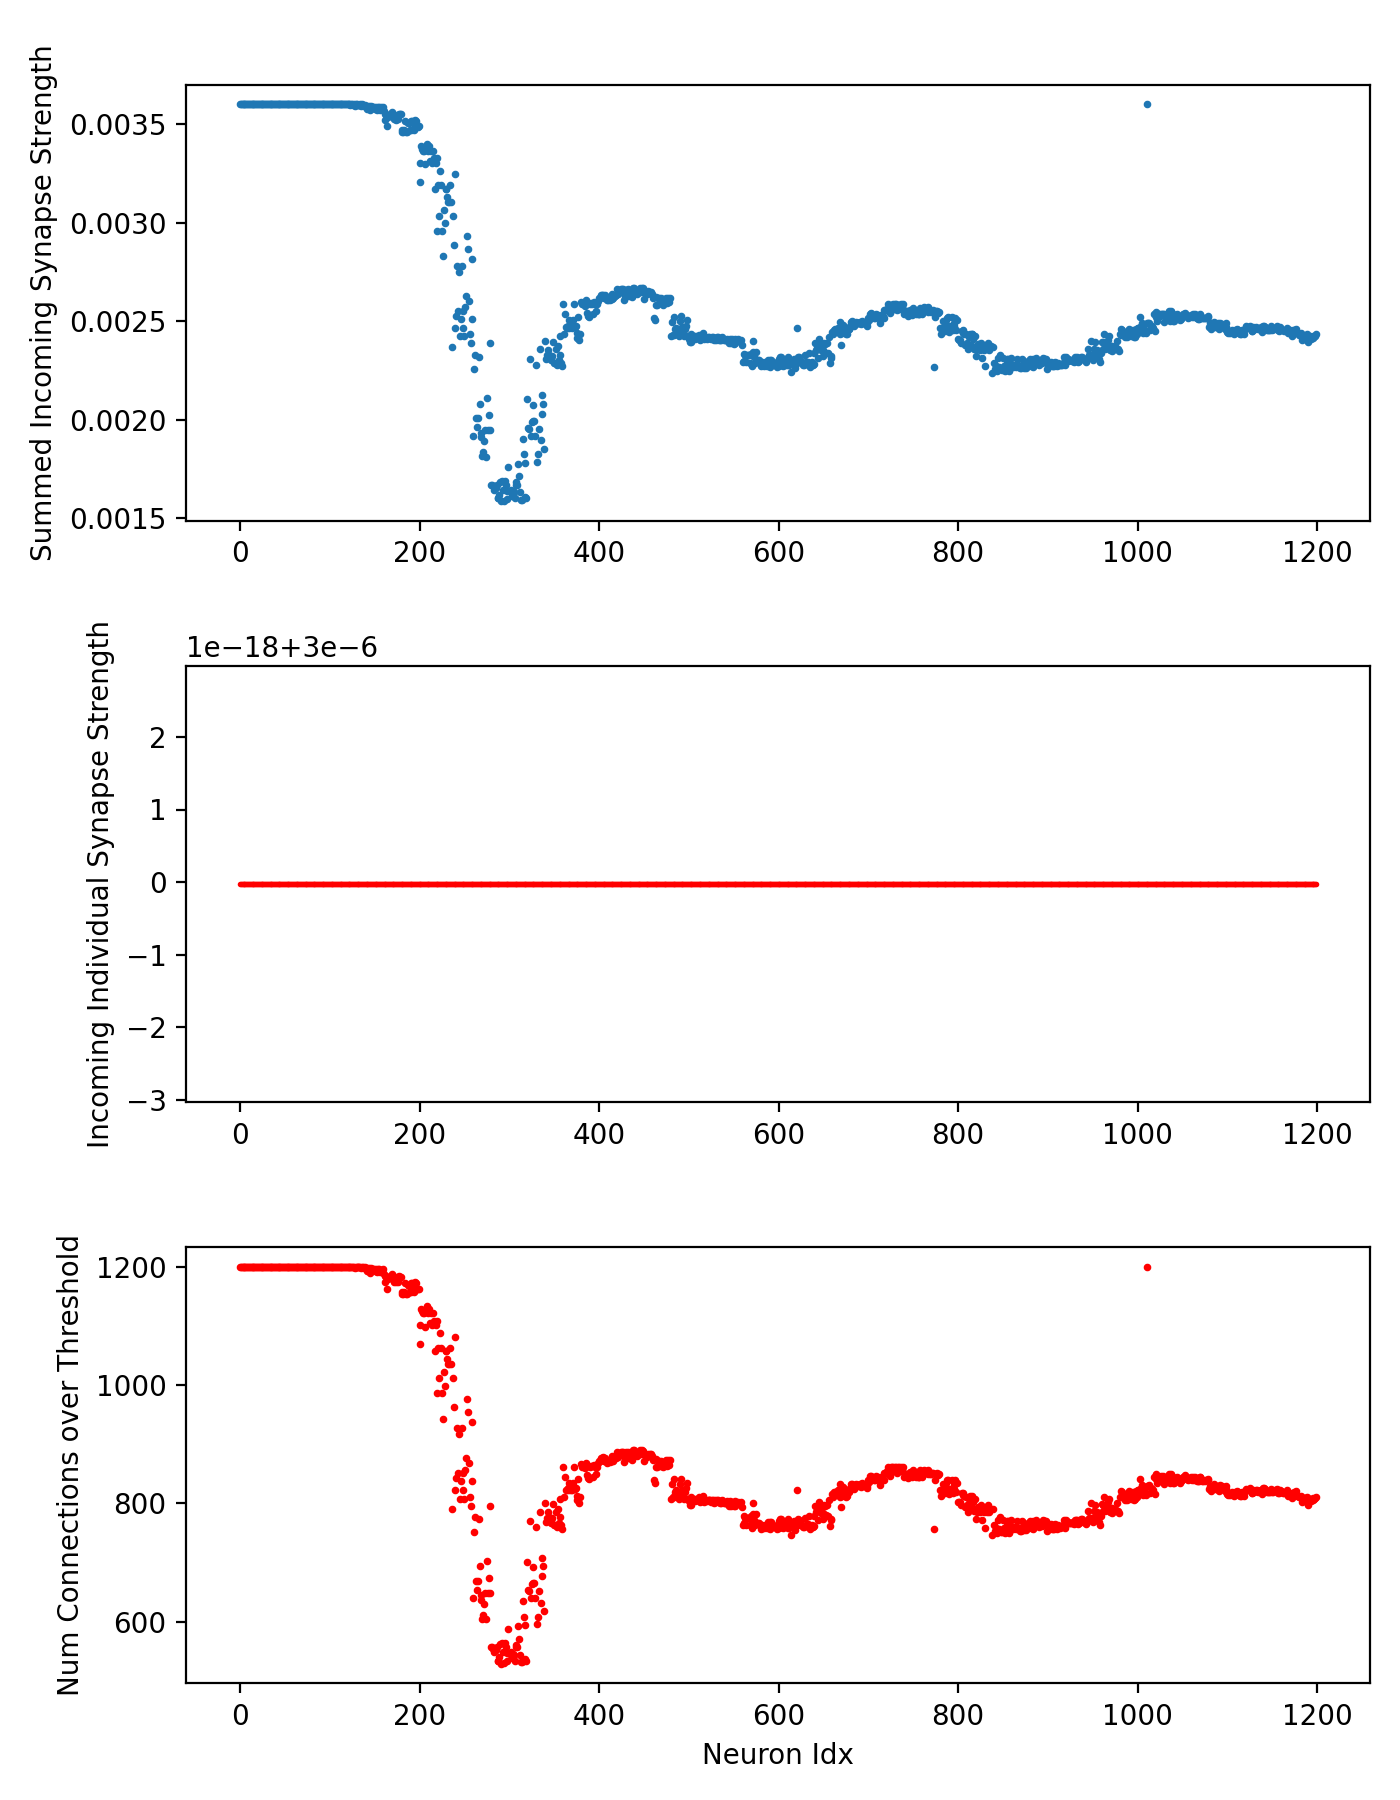

average summed incoming weight per cell: 0.0026182099999999763 +/- 0.0004931379887009256
average incoming connections per cell: 872.7366666666667 +/- 164.37932956697713


In [37]:
plot_w_r(w_r_i_initial, row_max=1200, col_min=1200, col_max=2400)